# Juliaを使って動的計画法を解く
* 注意：チュートリアルセッションのためコードのコメントはすべて日本語にしていますが、一般的にプログラミングをする際のコメント(#の後に続く文章)は英語(半角)にしておいたほうが良いです
    * コメント行は実行されないため全角の日本語でも基本的に問題ないのですが、全角スペース　が実行文のどこかに入り込んだ場合、見つけ出すのに　苦労したりトラブルの元になります
* 以下ではTipsをメモ的に書いてあります。初めて読む場合、意味不明な可能性がありますが、その場合は読み飛ばしてもアルゴリズムの理解には問題ありません
    * ただ、Juliaを使って高速化したい場合、従うべきルールがあります
    * そこを無視してプログラムを書いた場合、動くけど「評判と違って全然早くない」という結果になるので注意してください

---

## 0. Jupyterの使い方
* JupyterはMarkdown形式のコメント部分(ココ)と実行部分(下)にわかれています
* [1]、[2]のように番号がある場所は実際に計算をする箇所
* ここでShift+Enterを押すと、実行結果が表示されます

### 試してみる

In [1]:
# Shift + Enterを押してみる
# 2と表示されなければ何かがおかしい...
1+1

2

---

## 1. Juliaコードが格納されているフォルダに移動
* 下は私の場合ので適宜、自分のコードが置いてある場所を指定してください

In [38]:
cd("/Users/TomoakiYamada/Documents/GitHub/Tutorial_JEA")

---

## 2. 必要なパッケージを読み込む
* パッケージは事前にインストールをしておいてください
* 初めて実行する場合、Info: Precompiling XXXのような文章が出る可能性があります
    * 高速化のためにパッケージをコンパイルしています
    * Plotsのprecompileに時間がかかる可能性あり

In [41]:
using Dierckx; # スプライン補間
using Optim; # 最適化(最小値を探す)
using Printf; # @printfを使う
using Plots; # 図を描く
pyplot(); # 図のバックエンドとしてPyPlotを使用

### 自分で書いた関数を読み込む

In [44]:
include("benchmark_spline/bellman_eq_sp.jl");
include("benchmark_linear/crra.jl");
include("benchmark_linear/grid_uni.jl");

---

## 3. カリブレーション
* モデルのパラメータを設定
* JuliaではUnicodeが使えるので$\alpha$とか$\beta$を直接コードの中にかける
    * 数式に近い形でコーディングができる
    * \alphaと打ち込んでTabキーを押すと変換可能：使用環境によっては出来ないかも
* 行の最後にある;は実行結果を表示させないため
    * なくても結果には影響しない
    * Jupyterで;を書かない場合、最後の実行の結果だけ表示される
* 1(整数)と1.0(浮動小数点)はコンピュータ上は別物なので注意
    * 今回の計算では問題ないが、Juliaの構造上、自分が扱っている変数の型(Type)が何かを意識することが計算の高速化につながる
    * というか、意識しないで適当に扱ってしまうと計算が遅くなる原因になる

In [42]:
β = 0.99; # discount factor
γ = 2.0; # relative risk aversion
r = 0.01; # interest rate
w = 1.0; # wage

---

## 4. 状態変数$a$の定義域を有限個の点の集まりとして表現する
* グリッド(grid)を生成

In [47]:
amax = 10.0; # グリッド(資産)の最大値
amin = 0.0; # グリッド(資産)の最小値
na = 101; # グリッドの数

In [48]:
# 上で読み込んだgrid_uniという関数を使って"等間隔"のグリッドを生成
agrid = grid_uni(amin, amax, na);

---

## 5. 価値関数(value function)の初期値を設定(initial guess)
* na個に区切ったグリッド上の価値関数の初期値を与える
* 縮小写像定理(contraction mapping theorem)から価値関数は繰り返し計算によって収束する(はず)
    * 様々な近似誤差・計算誤差によって理論通りにならない可能性がある
* とりあえず次期の貯蓄をゼロとした場合の効用関数を初期値にしておく
    * よいinitial guessを与えられると収束までの計算回数を減らすことができる

In [56]:
# 空の変数を用意
vfcn0 = zeros(na);
vfcn1 = zeros(na);
pfcn0 = zeros(na);
pfcn1 = zeros(na);

### 持っている資産をすべて消費にまわす場合の効用関数を価値関数の初期値(vfcn1)とする
* 理論的な根拠はないのでこれにこだわる必要は特に無い

In [57]:
cons = (1 + r).*agrid .+ w;
vfcn1 = crra.(cons, γ);

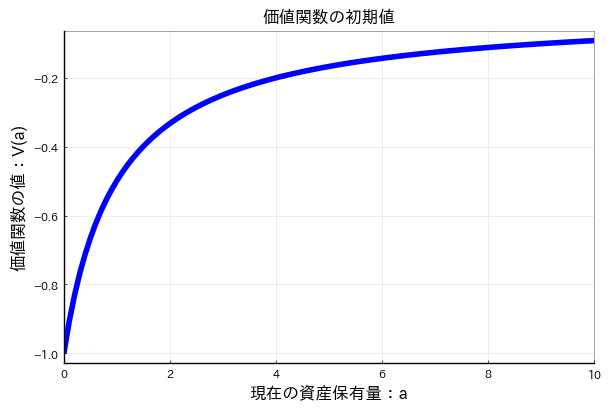

In [58]:
# 価値関数の初期値はこんなかんじ
plot(agrid, vfcn1,
    xlab = "現在の資産保有量：a",
    ylab = "価値関数の値：V(a)",
    title = "価値関数の初期値",
    linewidth = 4,
    color = :blue,
    legend = :none,
    framestyle = :semi,
    xlims = (0, 10),
    titlefont = font("IPAexGothic",12),
    guidefont = font("IPAexGothic",12),
    legendfont = font("IPAexGothic",8),
    tickfont = font("IPAexGothic",8))
savefig("figures/fig_value_ini.pdf")

---

## 6. Optimを使ってみる：価値関数をアップデート
* 1回だけOptimizationを試してみる
    * デモンストレーション用：実際はすぐにメインループに入ってOK
* Optimには様々な最適化の方法(オプション)がある
    * 今回はGolden Section Searchという方法で最小値を探す
* 詳細：https://julianlsolvers.github.io/Optim.jl/stable/#

### 価値関数をスプラインで近似する
* スプライン係数を計算

In [59]:
spl_coef = Spline1D(agrid, vfcn1, bc="extrapolate");

### グリッド上で価値関数を計算してみる

In [60]:
for i = 1:na
    # Golden Section Searchは両端を設定した上でその範囲内で極地(最小値)を探す方法
    # (-10,12)の範囲を指定：この範囲次第で極地が見つからなかったりするので、一般的には試行錯誤が必要な部分
    # あるいは速度を早くするために、別の最適化手法を試したり別のパッケージを探したり試行錯誤する部分
    res = optimize(x->bellman_eq_sp(x, agrid[i], spl_coef, β, γ, r, w), -10.0, 10.0, GoldenSection())
    pfcn0[i] = Optim.minimizer(res)
    vfcn0[i] = Optim.minimum(res)
end

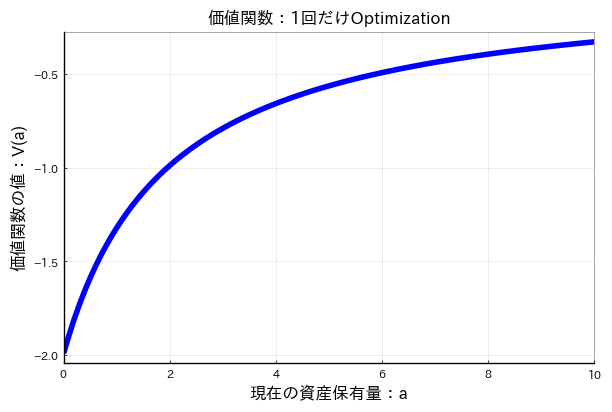

In [66]:
# 上で計算した価値関数の初期値から1回だけイテレーション
plot(agrid, -1*vfcn0,
    xlab = "現在の資産保有量：a",
    ylab = "価値関数の値：V(a)",
    title = "価値関数：1回だけOptimization",
    linewidth = 4,
    color = :blue,
    legend = :none,
    framestyle = :semi,
    xlims = (0, 10),
    titlefont = font("IPAexGothic",12),
    guidefont = font("IPAexGothic",12),
    legendfont = font("IPAexGothic",8),
    tickfont = font("IPAexGothic",8))
savefig("figures/fig_value_optim.pdf")

### 下は1回だけイテレーションした場合の政策関数
* 実質的に2期間モデルを解いたのと同じ
    * 現在の資産(a)のほぼ半分を次期(a')に回している

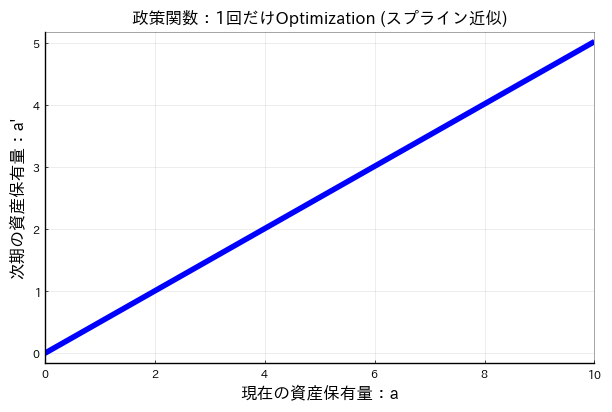

In [67]:
plot(agrid, pfcn0,
    xlab = "現在の資産保有量：a",
    ylab = "次期の資産保有量：a'",
    title = "政策関数：1回だけOptimization (スプライン近似)",
    linewidth = 4,
    color = :blue,
    legend = :none,
    framestyle = :semi,
    xlims = (0, 10),
    titlefont = font("IPAexGothic",12),
    guidefont = font("IPAexGothic",12),
    legendfont = font("IPAexGothic",8),
    tickfont = font("IPAexGothic",8))
savefig("figures/fig_policy_optim.pdf")

---

## 7. ベルマン方程式の中身
* functionを使う
* """で囲まれた領域はコメント文：helpで参照されるので再利用するコードはきちんと書いておくと後々便利
* 関数の引数(a0とか)の型は明示的に示しておいたほうが良い：なくても動くけど遅くなる原因

In [144]:
"""
bellman_eq_sp(a1::Float64, a0::Float64,
           spl::Spline1D,
           β::Float64, γ::Float64, r::Float64, w::Float64)

Purpose:
Bellman equation.
Given next period's value function, return the current value.
Use "spline interpolation".

Input:
a1 → next period's asset (OPTIMIZE),
a0 → current asset,
vfcn → next period's value function,
β → discount factor,
γ → inverse of ies,
r → interest rate,
w → wage.

Output:
v0 → current period's value.
"""
function bellman_eq_sp(a1::Float64, a0::Float64,
                       spl::Spline1D,
                       β::Float64, γ::Float64, r::Float64, w::Float64)
    # consumption
    cons = (1 + r)*a0 + w - a1
    # CRRA utility function
    cons > 0 ? util = crra(cons, γ) : util = -1000000.0
    # use cubic spline interpolation to compute next period's value
    # need to install and load "Dierckx"
    v1 = spl(a1)
    # value function
    v0 = util + β*v1
    # use Minimization
    v0 = -1.0*v0
    return v0
end

value_function

---

## 8. メインループ

### 繰り返し計算誤差を設定

In [32]:
maxit = 1000;
vdif = zeros(maxit);
pdif = zeros(maxit);
ε1 = 1.0e-006;
ε2 = 1.0e-006;

### メインループの解説
* 最大でmaxit回の繰り返し計算
* ただし、繰り返し計算の誤差がε1あるいはε2より小さくなったら繰り返し計算をやめる：ループから抜け出す

In [68]:
for it = 1:maxit

    # スプラインの係数を予め計算しておく
    spl_coef = Spline1D(agrid, vfcn1, bc="extrapolate")

    for i = 1:na
        res = optimize(x->bellman_eq_sp(x, agrid[i], spl_coef, β, γ, r, w), -10.0, 15.0, GoldenSection())
        pfcn0[i] = Optim.minimizer(res)
        vfcn0[i] = Optim.minimum(res)
    end

    # ベルマン方程式(bellman_eq)の内部で一度-1をかけて符号を反転させている
    # これはOptimが最大値ではなく最小値を探しているため
    # そのため再度、符号を反転して元のベルマン方程式にする
    vfcn0 = -1*vfcn0

    # 計算誤差
    vdif[it] = maximum(abs.((vfcn0 .- vfcn1)./vfcn0))
    pdif[it] = maximum(abs.((pfcn0 .- pfcn1)./pfcn0))

    # 関数をアップデート
    vfcn1 = deepcopy(vfcn0)
    pfcn1 = deepcopy(pfcn0)

    if vdif[it] < ε1 || pdif[it] < ε2
        break
    end

end

---

## 結果を出力

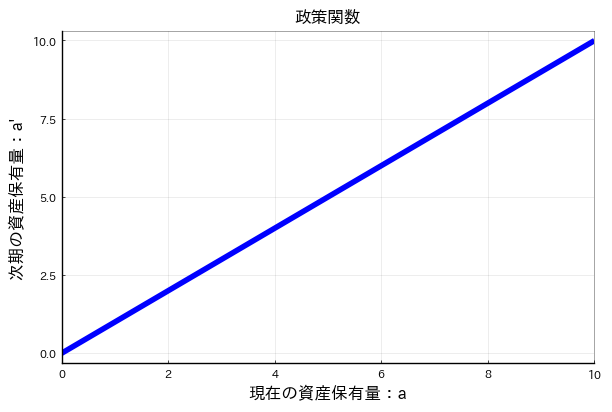

In [69]:
plot(agrid, pfcn1,
    xlabel = "現在の資産保有量：a",
    ylabel = "次期の資産保有量：a' ",
    title = "政策関数",
    linewidth = 4,
    color = :blue,
    legend = :none,
    framestyle = :semi,
    xlims = (amin, amax),
    titlefont = font("IPAexGothic",12),
    guidefont = font("IPAexGothic",12),
    legendfont = font("IPAexGothic",8),
    tickfont = font("IPAexGothic",8))
savefig("figures/fig_policy_function_sp.pdf")

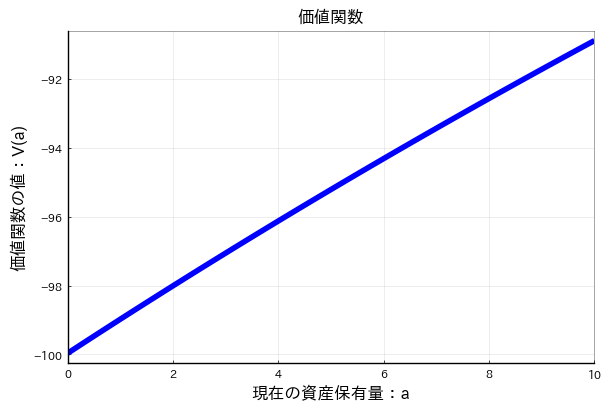

In [71]:
plot(agrid, vfcn1,
    xlab = "現在の資産保有量：a",
    ylab = "価値関数の値：V(a)",
    title = "価値関数",
    linewidth = 4,
    color = :blue,
    legend = :none,
    framestyle = :semi,
    xlims = (amin, amax),
    titlefont = font("IPAexGothic",12),
    guidefont = font("IPAexGothic",12),
    legendfont = font("IPAexGothic",8),
    tickfont = font("IPAexGothic",8))
savefig("figures/fig_value_function_sp.pdf")